In [ ]:
# import dependencies
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
import pandas as pd
import pandas_gbq as gbq
project_name = 'qtm-essay'
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.impute import MissingIndicator
from datetime import datetime
import math

# Modeling Taxi Tipping using Inferred Passenger Characteristics


<img src= "images/greencab.png">

### Intro

By the time a taxicab has arrived at its passengers' destination, the taxi's information system will have collected a variety of data reflecting ride characteristics. Pickup time, location, trip duration, number of passengers, surcharges, tolls, and more manifest in datasets containing the attributes of the tens of millions of taxi rides taken each year by New Yorkers. For the most part, these characteristics are known to drivers before they complete their trip; drivers can estimate the trip duration and can predict any tolls they might face on the way. Most prior attempts at prediction have, importantly, attempted to analyze the effect of these various factors on taxi fare amounts. Yet, fares fail to paint the full picture. Until the completion of a trip, taxi drivers remain uncertain about their trip earnings. 

### Project Motivation

Taxi drivers depend on tips for approximately 17% of their based taxi income - the average tip is 17%. Since there is a wide variation (how much variance? what is the range) in tipping across types of trips and customers, there is reason to value predictions about tipped amounts. Better prediction of tipped amounts should enable taxi-drivers to allocate their services better and maximize revenue. If we choose to understand tipping as a factor of the consumer surplus implicit in a trip, then tipped amounts might be an indicator of potential improvements to other fare models that do not include tips. Lastly, in the long term, models that predict tipping might serve as coal-mine canaries for a possible dying tipping culture.


Can even anonymised, vague information be predictive of taxi occupant behaviors? How valueable are geolocation data to purveyors of services? Comprehensive gelocation effects on revenue streams may be important for investors, public policy designers, and drivers. Evidence of discrimination, statistical or otherwise, may surface. 


## The Data

#### Taxi Trip Data

This project uses publicly available data on taxi trips provided by Google via '[bigquery-public-data](https://cloud.google.com/bigquery/public-data).'  These data are separated into 5 distinct tables, each of which contains data for 1 calendar year of trips.

The bigquery data are separated into different tables for each year. Tables for taxi trips occuring between 2014 and 2017 share the same schema. Geolocation data does not exist in the 2018 data: unfortunate. 

In [ ]:
# Load queries to local env.
green_pickup_visualization_query = open("green_pickups_2016.sql", 'r').read()
green_dropoff_visualization_query = open("green_dropoff_2016.sql", 'r').read()
green_main_query = open('greencab_sample.sql', 'r').read()

# Pass queries to GBQ and store in DataFrame
green_pickups_2016 = pd.io.gbq.read_gbq(green_pickup_visualization_query, project_id = project_name)
green_dropoff_2016 = pd.io.gbq.read_gbq(green_dropoff_visualization_query, project_id = project_name)

# See schema for documentation
green_all = pd.io.gbq.read_gbq(green_main_query, project_id = project_name)

#### Geolocation Data

Python pacakge 'uszipcode' contains several social and economic indicators tied to localities across the United States. The package does include functionality that enables access to indicators at a more granular geographic level than a zip code, including extensive real-estate and housing information, but those data are largely incomplete. 

Additionally, the computational complexity of the package's search features already slows implementation to a crawl: simply finding the zip_codes for each reference location in our dataset of 755000 taxi trips already takes as long as 40 minutes. <sup>[1](#footnote1)</sup>

In [ ]:
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
searchEngine = SearchEngine()

#### Feature Selection and Hypothesis Specification

While its true that we could just dredge the data, throw feature columns at the proverbial wall to 'see what sticks' that approach won't give us any insight into the relationships in the data that might be of interest to relevant parties. This project uses a curated set of features from both datasets, and computes a few additional features which are occasioanlly used in econometric discussions of similar issues. 

### Feature Set
##### Trip Reported Data
`Fare`: The metered fare at the end of a trip. Higher fares may be associated with higher tips if income effects dominate wealth effects - such fares may be associated with lower tips if the inverse is true.  <br />
`Time of Day`: Date-times are split into the following 6 zones: 3 AM - 9AM, 9AM - 3 PM, 3 PM - 9PM, 9PM -3AM. <br />
`Weekend`: 1 on Sunday and Saturday, 0 otherwise. <br />
`Month`: Months, in calendar order. <br />
`Year`: Having both year and month allows us to identify wether or not there are any seaonsal, long term trends in tipping. <br />
`Passenger Count`: The number of reported passengers for each given trip. Reporting is inconsistent, so it's not expected that passenger count be a strong predictor. <br />
##### Location specific indicators

Each location indicator is computed for both the starting location for each trip (pickup) and the end location (dropoff). 

`Borough`: The NYC Borough associated with the pickup or dropoff <br />
`Median home value`: Median home values for the zip code associated with the location. <br />
`Median household income`: Median incomes at the location. <br />
`Population Per Home`: The ratio of the zip code's popualtion to the number of occupied units. <br />
`Vacancy rate`: The ratio of unoccupied units to total housing units in a given zip code. <br />

The following three dummy indicators 

`Airport`: 1 if a trip ends at either of Laguradia or JFK Airports, 0 otherwise.<br />
`Station`: 1 if a trip ends at Penn Station, Grand Central Terminal, or annother notable commercial space, 0 othersiwe.<br />
`Cross Borough`: 1 if a trip ends in a different Boro than it begins, 0 otherwise.

### Challenges

1. Decision boundaries: 
2. Missing Data:  (specify which data are missing)
3. Clearly mislabeled data:
4. Outliers:
5. Innapropriate Scale: (working with income and financial data)
6. Computational and time constraints:


In [ ]:
# Color Mapping tool at: https://html-color-codes.info/colors-from-image/
# Colors taken from NYC Subway Map
matplotlib.rc('axes', **{'grid': False})
plt.rcParams['axes.facecolor'] = '#9ECAED'

# Pickups Graphic
green_pickups_2016.plot(kind='scatter', x='long', y='lat',
                        color='#009C60', xlim=(-74.06,-73.77),
                        ylim=(40.61, 40.91), s=.02, alpha=.8);

# Dropoffs Graphic
green_dropoff_2016.plot(kind='scatter', x='long', y='lat',
                        color='#009C60', xlim=(-74.06,-73.77),
                        ylim=(40.61, 40.91), s=.02, alpha=.8);

## Inferring Passenger Characteristics
#### Using Geolocation Data to add predictive power.

The constraint that trips must occur within New York City substantially limits the search space for our feature values, which, conveniently, reduces the computational runtime of the project. Each zip code in NYC falls in a numerical range between 10000 and 11500, so at most, we only have to find information for 1150 zip codes. Since some zip codes do not exist at all, the actual number of returned zip codes is even smaller.

The following code attempts a few objectives:
1. It finds, and locally stores, demographic and economic indicators associated with every NYC zip code.
2. It adresses outlier values. <sup>[2](#footnote2)</sup>
3. It generates dummy columns for heavily frequented destinations with no associated demographics (airports and manhattan train stations).
4. It handles missing data, most often by imputing Borough medians for missing values. 
5. It constructs derrivative features (vacancy rate, population per houshold).
6. It transforms features with improper scale (log transforming income, housing values).

In [242]:
# Init search engine object for SQLalchemy Database. 
# See uszipcode package documentation

def generate_zip_code_metadata(engine):
    """ Build table with ZIP codes and geolocation specific data. 
    Inputs: uszipcode SearchEngine() object, column header prefix
    """
    
    # initing list and looping over 1 range is 6x faster than list comprehensions.
    # Pardon the unpythonic.
    zip_codes = []
    population = []
    housing_units = []
    occupied_housing_units = []
    median_home_value = []
    median_household_income = []
    county = []
    
    
    for i in range(10000, 11500):
        zip_data  = engine.by_zipcode(i)
        
        if zip_data.zipcode != None: # only append if zip code is real
            zip_codes.append(i)
            population.append(zip_data.population)
            housing_units.append(zip_data.housing_units)
            occupied_housing_units.append(zip_data.occupied_housing_units)
            median_home_value.append(zip_data.median_home_value)
            median_household_income.append(zip_data.median_household_income)
            county.append(zip_data.county)
            
    zip_frame = pd.DataFrame({'zip_codes' : zip_codes,
                              'population' : population,
                              'housing_units' : housing_units,
                              'occupied_housing_units' : occupied_housing_units,
                              'median_home_value' : median_home_value,
                              'median_household_income' : median_household_income,
                              'county': county})
        
        
    # Ignores Staten Island and New Jersey
    boros = ['Queens County', 'Kings County', 'New York County', 'Bronx County']
    zip_frame = zip_frame[zip_frame['county'].isin(boros)] 


    # Append bool for indicator dummy for locations with no known
    stations = [10103, 10119, 10165, 10170, 10173, 10119, 10199] # Penn/MSG, GCT        
    airports = [11430, 11371] # LGA, JFK Respectively
    zip_frame['station'] = zip_frame['zip_codes'].isin(stations)
    zip_frame['airport'] = zip_frame['zip_codes'].isin(airports)


    # Log scale income, then populate missing w/ median
    zip_frame.replace([0, np.nan], 1, inplace = True)
    nyc_median_income = np.log(57782)
    zip_frame['median_household_income'] = zip_frame['median_household_income'].transform(lambda x: np.log(x))
    zip_frame['median_household_income'] = zip_frame['median_household_income'].transform(lambda x: nyc_median_income * 
                                                                                          (x == 0.0)) + zip_frame['median_household_income']


    # Log scale home value, impute medians
    zip_frame['median_home_value'] = zip_frame['median_home_value'].transform(lambda x: np.log(x))
    boro_mhvs = {'Kings County': np.log(808000), 
                 'New York County': np.log(1550000), 
                 'Queens County' : np.log(605000),
                 'Bronx County': np.log(515000)}

    
    for boro in boro_mhvs:
        mhv = boro_mhvs[boro] # value        
        zip_frame['median_home_value'] = (mhv * (zip_frame['median_home_value'].isin([0.]) * 
                                          zip_frame['county'].isin([boro]))) + zip_frame['median_home_value']


    # Compute avg. home occupancy by zip code, define outliers, impute median
    zip_frame['pop_per_home'] = zip_frame['population'] / zip_frame['occupied_housing_units']
    pph_outliers = [10119, 10199, 11430]
    zip_frame['pph_outlier'] = zip_frame['pop_per_home'].median() * zip_frame['zip_codes'].isin(pph_outliers)
    zip_frame['pph_non_outlier'] = zip_frame['pop_per_home'] * (1 - zip_frame['zip_codes'].isin(pph_outliers)) 
    zip_frame['pop_per_home'] = zip_frame['pph_outlier'] + zip_frame['pph_non_outlier']


    # Compute the vacancy rate for each neighborhood.
    zip_frame['vacancy_rate'] = zip_frame['occupied_housing_units'] / zip_frame['housing_units']
    zip_frame['vacancy_rate'] = zip_frame['vacancy_rate'].transform(lambda x: 1 - x)


    # Drop reckless columns
    zip_frame = zip_frame.drop(columns = ['population', 'housing_units', 'occupied_housing_units',
                                          'pph_outlier', 'pph_non_outlier'])
    
    
    return zip_frame

zip_frame = generate_zip_code_metadata(searchEngine)

#### Getting Zip Codes for Each Location


In [ ]:
def find_zip_codes(engine, df, lon_lat_cols, string):
    """Adds column with zip codes corresponding to numerical coordinates for PD DataFrame
    Inputs: 
        1. uszipcode SearchEngine() object
        2. pandas dataframe with numeric columns representing longitude, latitude
        3. list of len 2 where entry 0 is the string column header for df longitude, 
           entry 1 is string column header for df latitude
        4. string header for output column name. 
    Returns: input DF with appended zip code column.
    """

    col_names = lon_lat_cols
    zip_codes = []
    
    for i in range(0, len(df)):        
        zip_data  = engine.by_coordinates(df[col_names[0]].iloc[i],
                                          df[col_names[1]].iloc[i],
                                          returns = 1, radius = 2)
        if zip_data == []:
            zip_codes.append('not found')
        else:
            if int(zip_data[0].zipcode) > 10001 and int(zip_data[0].zipcode) < 11500:
                zip_codes.append(zip_data[0].zipcode)
            else:
                zip_codes.append('not found')
                
            
    zip_codes = pd.DataFrame({string: float(zip_codes)})
    updated_df = pd.concat([df, zip_codes], axis = 1)
    return updated_df

# Append zips
green_all = find_zip_codes(searchEngine, green_all, ['pickup_lat', 'pickup_long'], 'pickup_zip')
green_all = find_zip_codes(searchEngine, green_all, ['dropoff_lat', 'dropoff_long'], 'dropoff_zip')

# remove entries with out of bounds zip codes
green_all = green_all[green_all['pickup_zip'] != 'not found']
green_all = green_all[green_all['dropoff_zip'] != 'not found']

# Converting Zip codes to numeric types
green_all['pickup_zip'] = pd.to_numeric(green_all['pickup_zip'])
green_all['dropoff_zip'] = pd.to_numeric(green_all['dropoff_zip'])

In [ ]:
pickup_zip_frame = zip_frame.add_prefix("pickup_")
dropoff_zip_frame = zip_frame.add_prefix("dropoff_")


green_merged = pd.merge(green_all, pickup_zip_frame, how = 'left', left_on = 'pickup_zip',
                        right_on = 'pickup_zip_codes')
green_merged = pd.merge(green_merged, dropoff_zip_frame, how = 'left', left_on = 'dropoff_zip',
                        right_on = 'dropoff_zip_codes')

# Last Minute Filtering
green_merged['cross_boro'] = green_merged['dropoff_county'] != green_merged['pickup_county']
green_merged = green_merged[green_merged['tip_percent'] < 1] # we could have filtered in the SQL but we'll do it here

In [ ]:
# Removing Columns 
drop_cols = ['tip', 'pickup_long', 'pickup_lat', 'dropoff_long', 
             'dropoff_lat', 'pickup_zip', 'dropoff_zip',
            'pickup_airport', 'pickup_station', 'dropoff_zip_codes', 'pickup_zip_codes']
green_merged = green_merged.drop(columns = drop_cols)

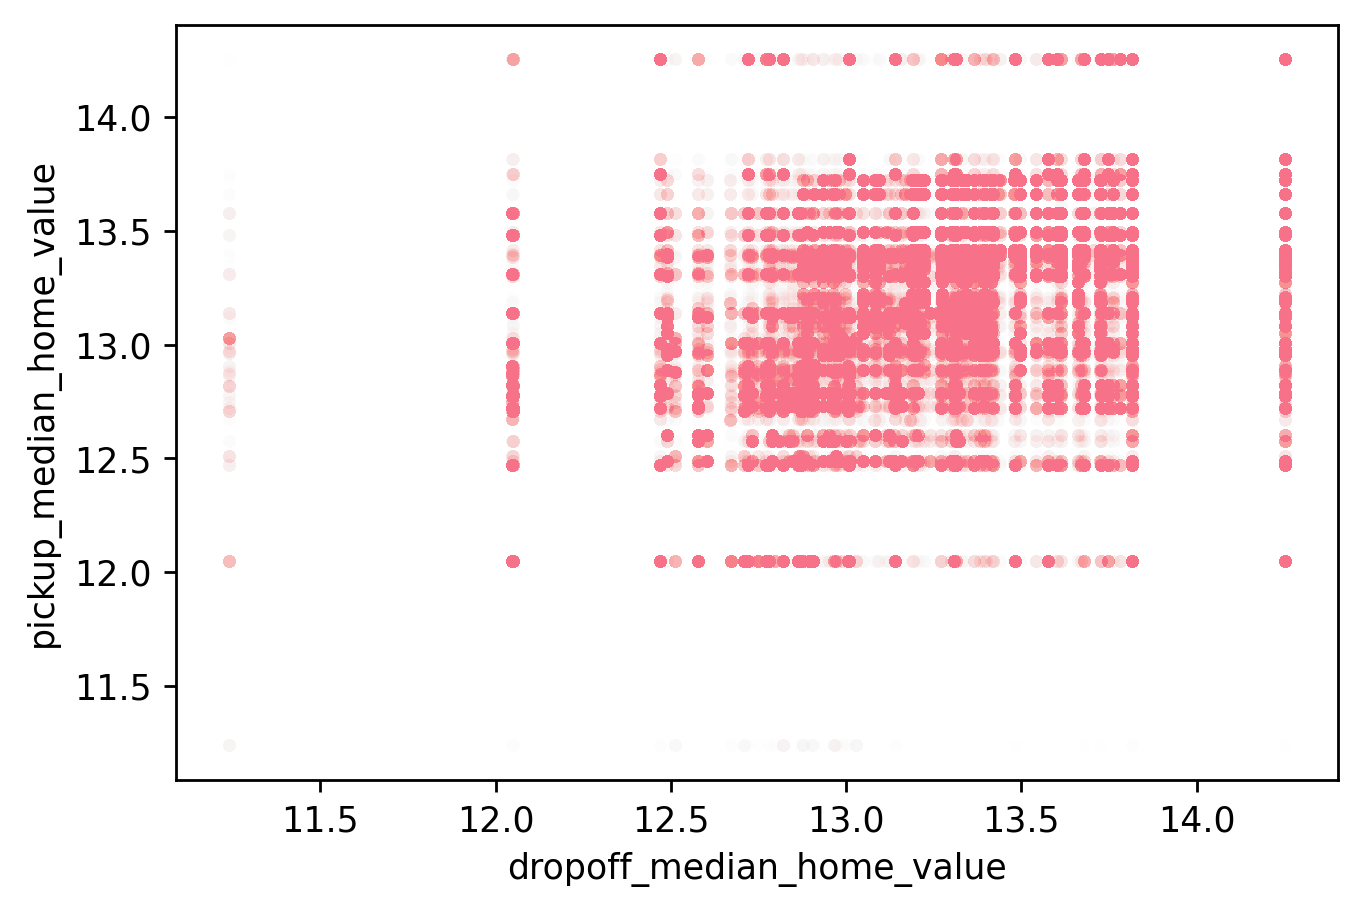

In [286]:
sns.scatterplot("dropoff_median_home_value", "pickup_median_home_value", 
           data = green_merged,
           s = 15, alpha = 0.005);

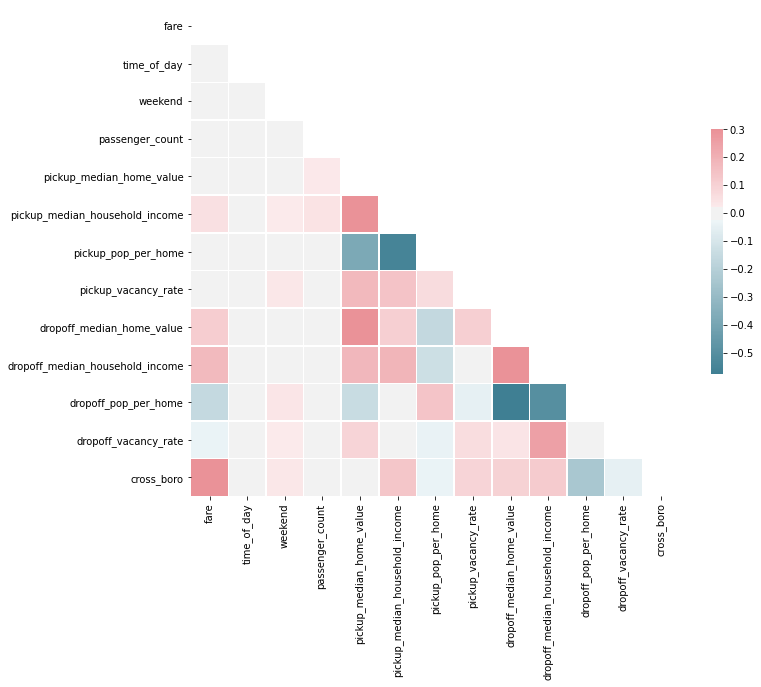

In [269]:
corr = green_merged.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

The upward trendline just shows that there are trips that end in manhattan, which has higher property values than the outerlying boros, while there are no trips from Manhattan south of 92nd street.

It's also the case that none of our predictor variables are multicolinear, or even highly correlated with each other. 

In [ ]:
target = green_merged.pop('tip_percent').values

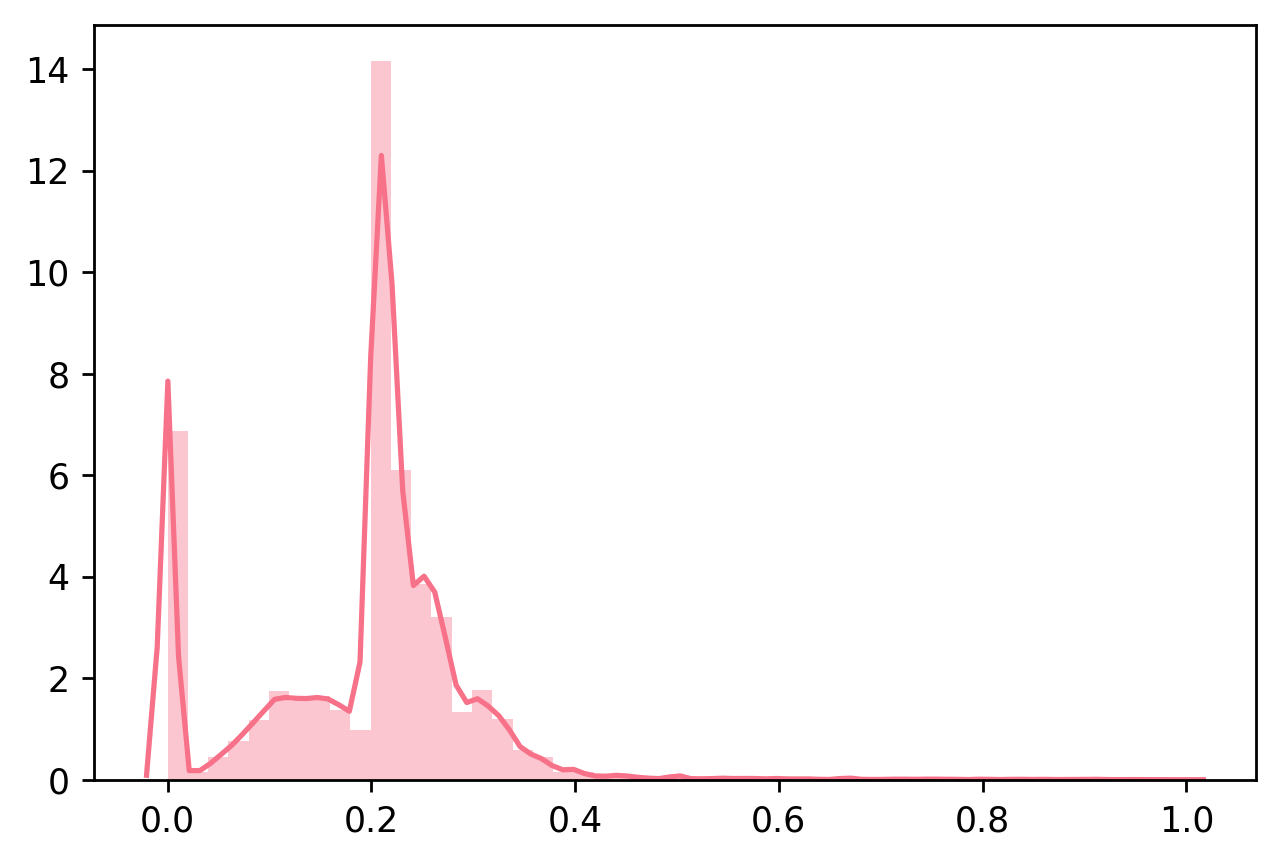

In [278]:
sns.distplot(target);

<a name="footnote1">1</a>: This runtime could be substantially reduced with a location specific hashmap that stores zip_codes already returned by the search. Since I've already stored them locally, I'm not going to do that, but the implementation is not complex.

<a name="footnote2">2</a>: Outlier values were identified with EDA on these data. The EDA is omitted, since most of it was not aesthetically appealing.